In [ ]:
!pip install keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.layers import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
tf.random.set_seed(2)
np.random.seed(1)
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
InputPath="/content/drive/MyDrive/AI proj/archive/images/images/art and culture"

In [ ]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.0001
        sigma = var**0.05
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy =  gauss + image
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 1.0
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(image.size * s_vs_p)
        coords = [np.random.randint( 0, i, size=int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(image.size * (1. - s_vs_p))
        coords = [np.random.randint( 0, i, size=int(num_pepper))
              for i in image.shape]
        out[coords] = 1
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)
        noisy = image + image * gauss
        return noisy

REal Image

255

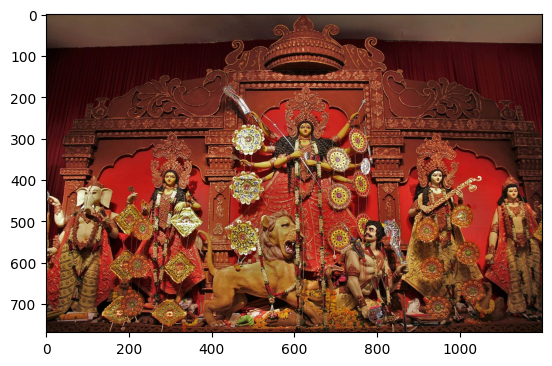

In [ ]:
img = cv.imread(InputPath + "/0 (3).jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.imshow(img)
l

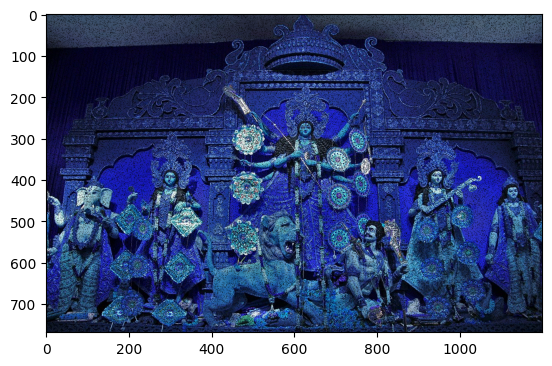

In [ ]:
def noisy(noise_typ, image):
    if noise_typ == "s&p":
        row, col, _ = image.shape
        s_vs_p = 0.5
        amount = 0.04
        out = np.copy(image)

        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[coords[0], coords[1], :] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords[0], coords[1], :] = 0
        return out

# Apply noise to the image
Noise = noisy("s&p", img)

# Display the noisy image
plt.imshow(cv.cvtColor(Noise, cv.COLOR_BGR2RGB))
plt.show()

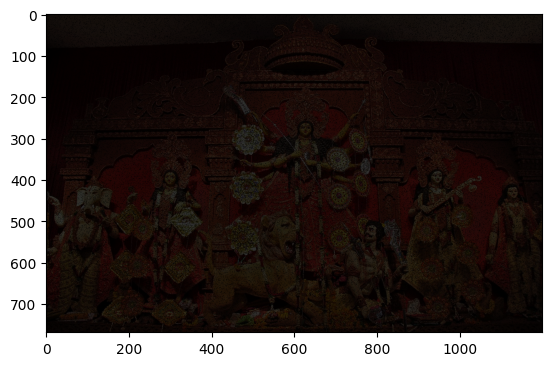

In [ ]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = noisy("s&p",img1)

plt.imshow(Noise2)

In [ ]:
def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageDir in os.listdir(ImagePath):
        if count<50:
            try:
                count=count+1
                img = cv.imread(ImagePath + imageDir)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img_y = cv.resize(img,(256,256))
                hsv = cv.cvtColor(img_y, cv.COLOR_BGR2HSV) #convert it to hsv
                hsv[...,2] = hsv[...,2]*0.2
                img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
                Noisey_img = noisy("s&p",img_1)
                X_.append(Noisey_img)
                y_.append(img_y)
            except:
                pass
    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_,y_

In [ ]:
X_,y_ = PreProcessData(InputPath)

In [ ]:
K.clear_session()
def InstantiateModel(in_):

    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)

    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_add = add([model_1,model_2,model_2_0])

    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)

    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)

    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)

    model_add_2 = add([model_3_1,model_3_2,model_3])

    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)
    #Extension
    model_add_3 = add([model_4_1,model_add_2,model_4])

    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)

    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)

    return model_5

In [ ]:
Input_Sample = Input(shape=(256, 256,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

In [ ]:
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         4640      ['conv2d[0][0]']              
                                                                                              

In [ ]:
!pip install utils



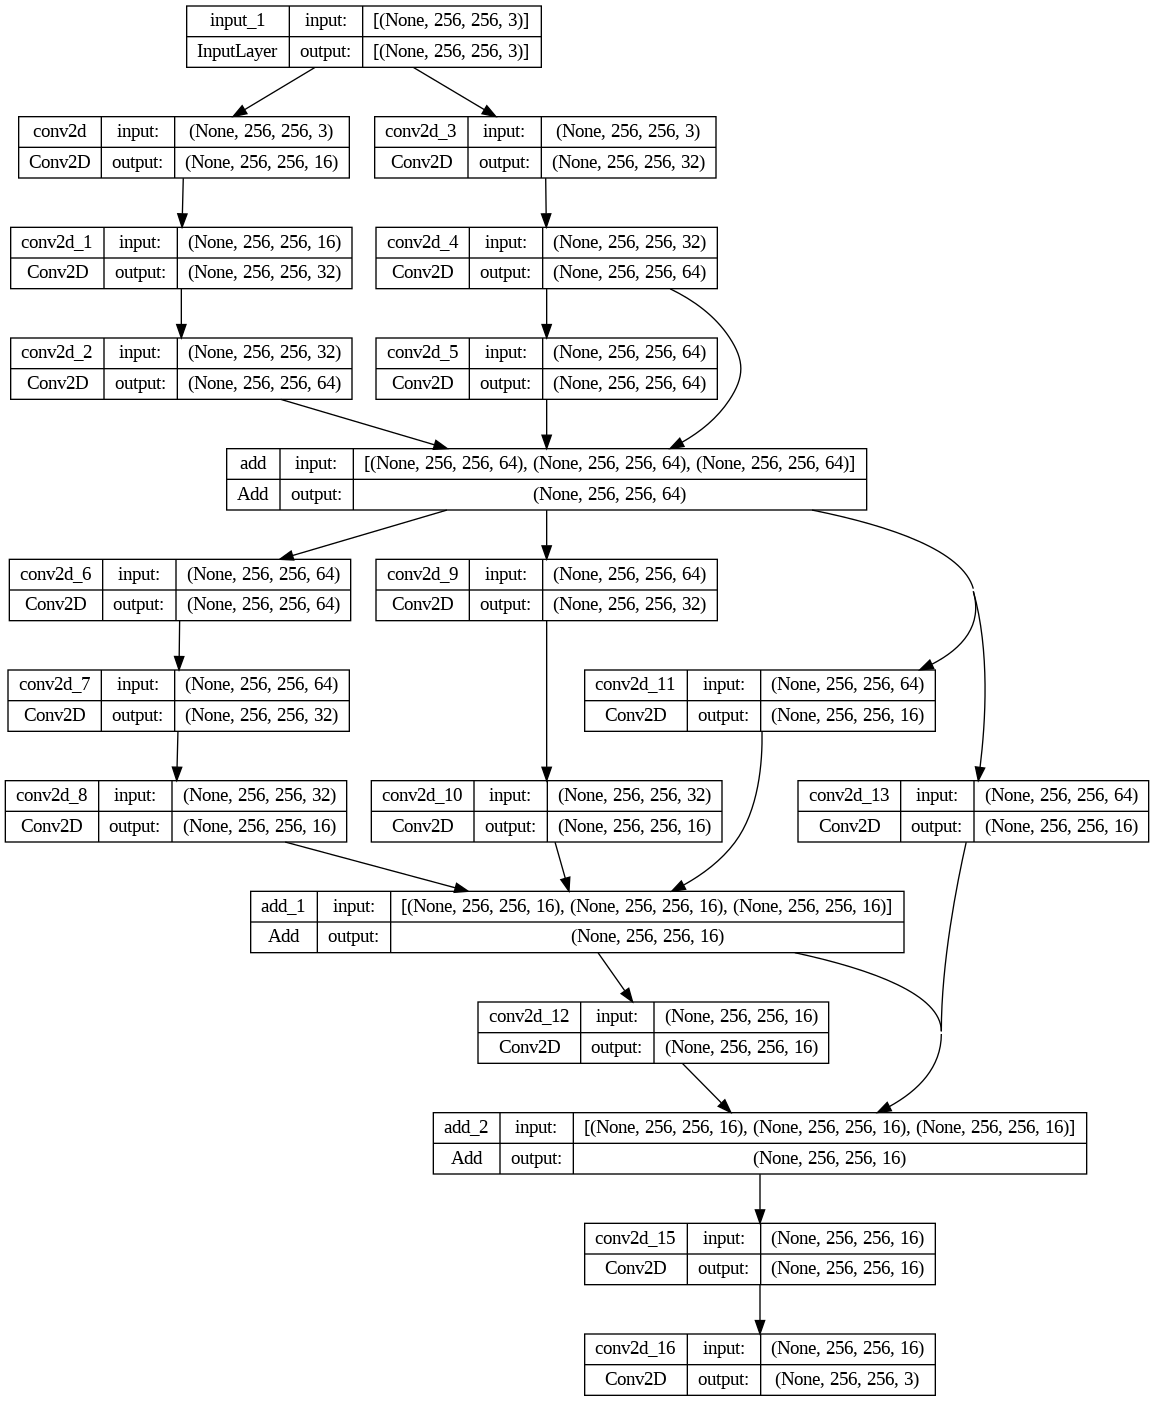

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [ ]:
epochs = 10
batch_size = 32

for epoch in range(epochs):
    indices = np.random.permutation(len(X_))
    for i in range(0, len(X_), batch_size):
        batch_indices = indices[i:i + batch_size]
        X_batch = np.array([X_[idx].reshape(256, 256, 3) for idx in batch_indices])
        y_batch = np.array([y_[idx].reshape(256, 256, 3) for idx in batch_indices])
        Model_Enhancer.fit(X_batch, y_batch, batch_size=batch_size, epochs=1, verbose=1, shuffle=True)


In [ ]:
TestPath="/content/drive/MyDrive/AI proj/archive/images/images/art and culture/"

In [ ]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(256,256))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = noisy("s&p",img1)
    Noise = Noise.reshape(1,256,256,3)
    return Noise

In [ ]:
ImagePath=TestPath+"101 (6).jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)



1/1 [==============================] - 1s 941ms/step


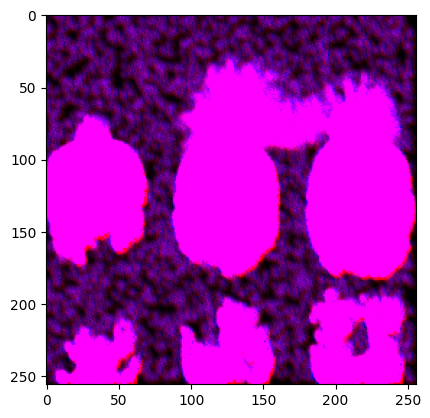

In [ ]:
Prediction = Prediction.reshape(256,256,3)
plt.imshow(Prediction)

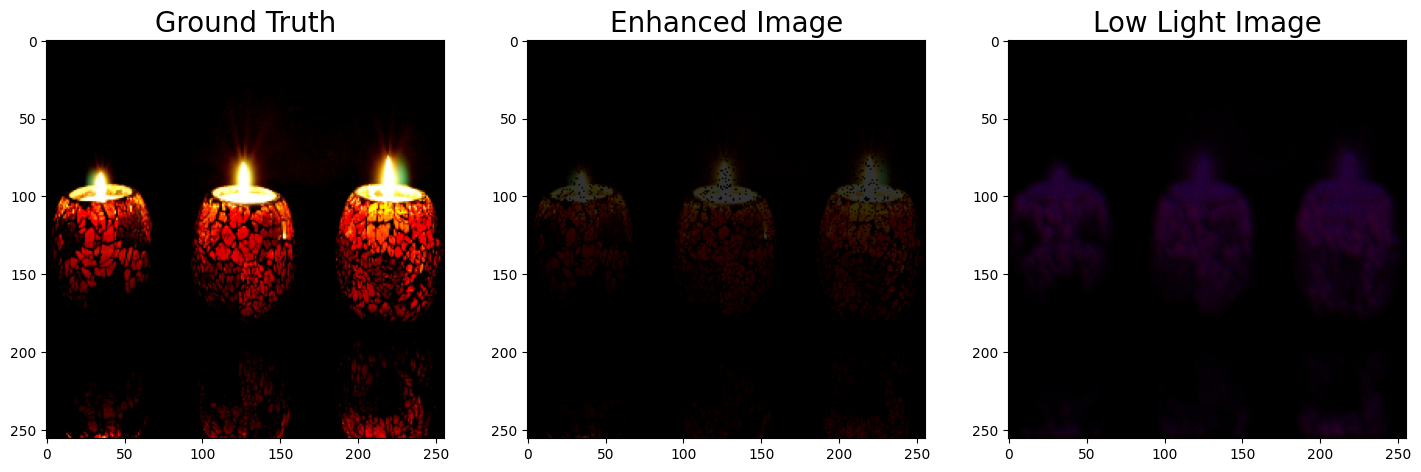

In [ ]:
Image_test=TestPath+"101 (6).jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (256, 256))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test)
img_ = img_.reshape(256,256,3)
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

travel and adventure

In [ ]:
TestPath2 = "/content/drive/MyDrive/AI proj/archive/images/images/travel and  adventure"

[[[ 29  40 120]
  [ 26  37 121]
  [ 34  42 135]
  ...
  [ 91 109 170]
  [ 83 100 157]
  [ 74  91 147]]

 [[ 28  41 120]
  [ 26  37 121]
  [ 32  43 135]
  ...
  [114 131 194]
  [104 122 181]
  [ 97 114 171]]

 [[ 14  32 109]
  [ 14  30 113]
  [ 23  38 131]
  ...
  [131 148 215]
  [122 138 204]
  [113 130 193]]

 ...

 [[228 178 160]
  [222 174 156]
  [230 187 170]
  ...
  [226 210 211]
  [214 198 199]
  [209 193 194]]

 [[234 184 164]
  [218 171 150]
  [240 198 179]
  ...
  [222 206 207]
  [211 195 196]
  [212 196 197]]

 [[245 196 174]
  [221 177 154]
  [242 200 181]
  ...
  [219 203 204]
  [213 197 198]
  [221 205 206]]]
1/1 [==============================] - 0s 324ms/step


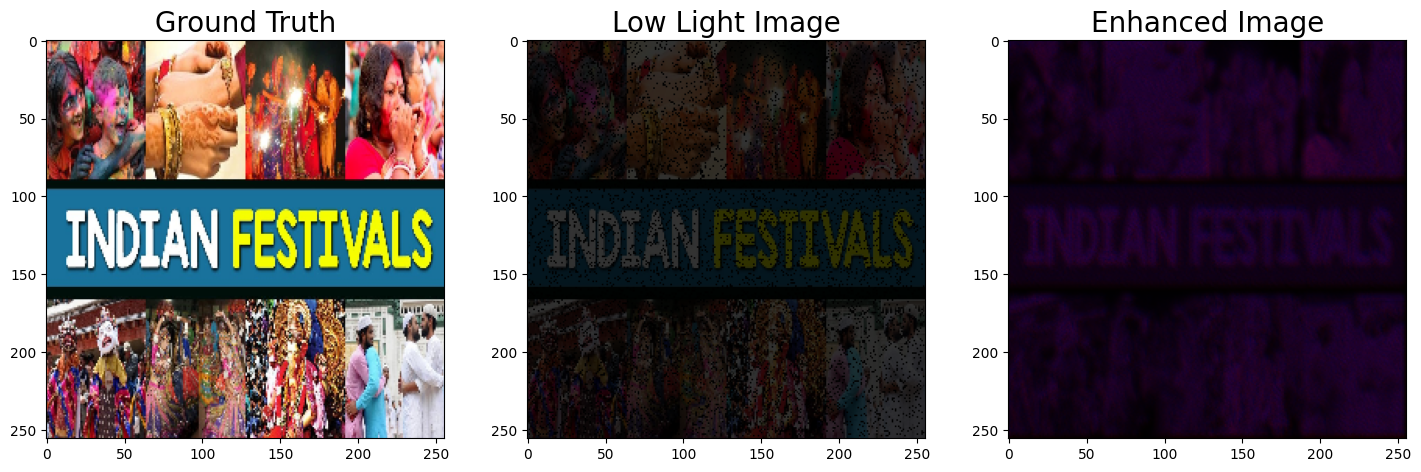

In [ ]:
Image_test2="/content/drive/MyDrive/AI proj/archive/images/images/art and culture/0.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
print(img_1)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (256, 256))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(256,256,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(256,256,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

1/1 [==============================] - 1s 650ms/step


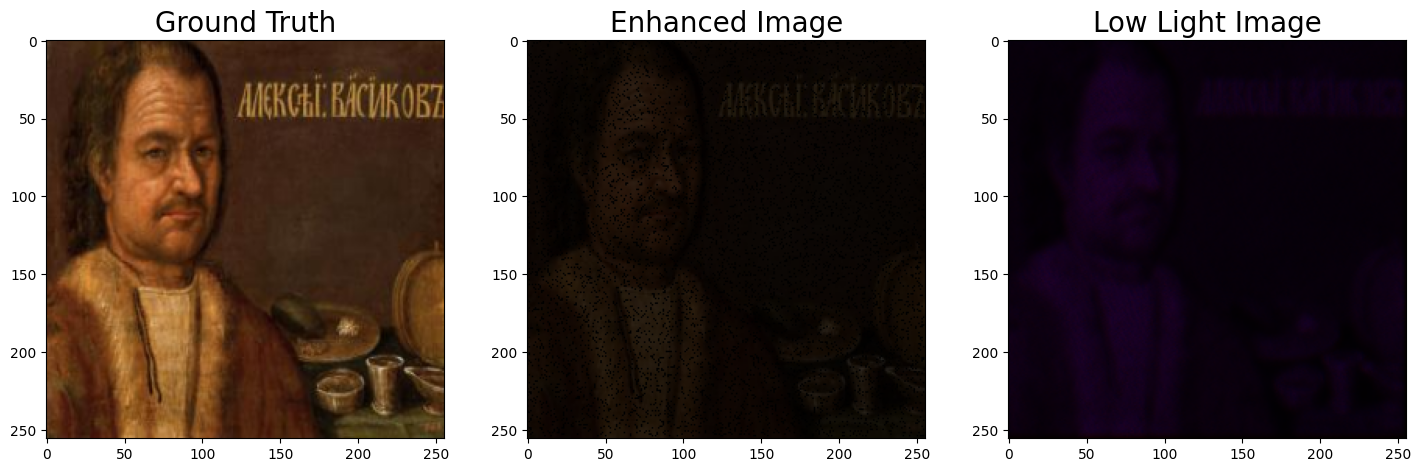

In [ ]:
Image_test2="/content/drive/MyDrive/AI proj/archive/images/images/art and culture/0007.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (256, 256))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(256,256,3)
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(256,256,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

1/1 [==============================] - 1s 594ms/step


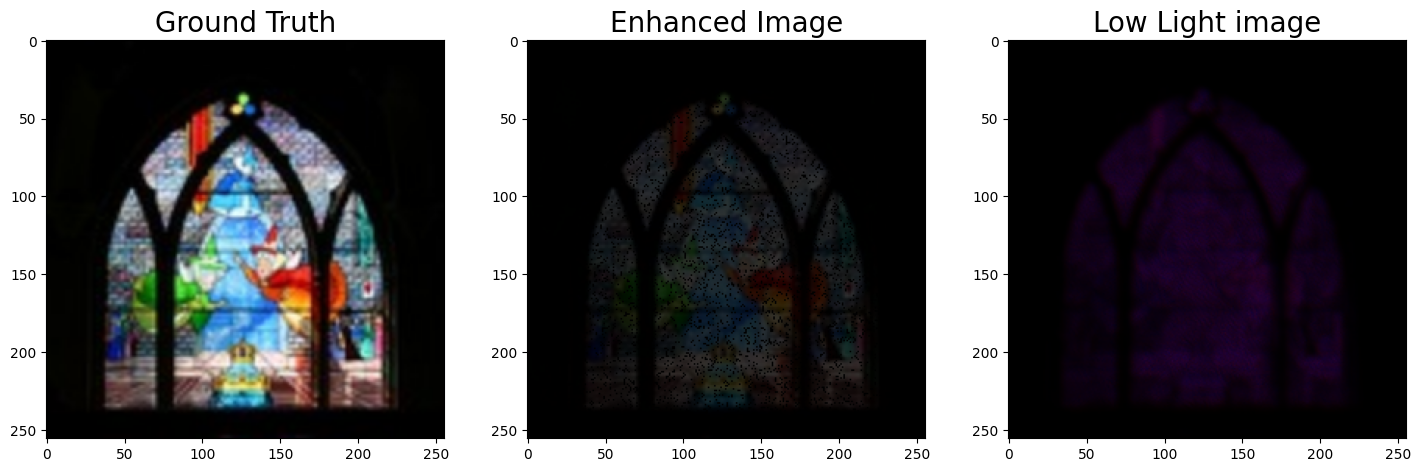

In [ ]:
Image_test2="/content/drive/MyDrive/AI proj/archive/images/images/architecure/10015159004_5f525f946d.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (256, 256))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(256,256,3)
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(256,256,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Low Light image",fontsize=20)
plt.imshow(img_)